# E10. 프로젝트: 인물 모드 문제점 찾기

**루브릭**

아래의 기준을 바탕으로 프로젝트를 평가합니다.

|평가문항|	상세기준|
|:-------|:-----------|
|1. 인물모드 사진을 성공적으로 제작하였다.|아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.|
|2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.|인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.|
|3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.|추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.|

## Step 0. 사용할 패키지 불러오기¶

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib   # 웹에서 데이터를 다운로드 받을 때 사용

from matplotlib import pyplot as plt
import tensorflow as tf

## Step 1. 인물모드 직접 해 보기
* 여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 
  - 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
  - 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
  - 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 **크로마키 배경합성**을 시도해 볼 수도 있을 것입니다. 

여러분만의 환상적인 사진을 만들어 보면 어떨까요?

### Step 1-1. 최소 3장 이상의 인물모드 사진

#### Step 1-1-1. 이미지 파일 불러오기

In [2]:
# 이미지 파일 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/lyb1.jpg'  
img_orig = cv2.imread(img_path) 

print (img_orig.shape)
height, width, channel = img_orig.shape
print(height, width , channel)

(2944, 2208, 3)
2944 2208 3


#### Step 1-1-2. DeepLabModel 클래스를 만들기

In [3]:
# 구글에서 제공하는 모델 구조를 그대로 가지고 와서 DeepLabModel 클래스를 만들기
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

#### Step 1-1-3. 사전에 학습된 가중치 불러오기

In [4]:
# 사전에 학습된 가중치(pretrained weight)를 불러오기
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    # 구글이 제공하는 deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight을 다운로드 
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

# DeepLabModel 초기화
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-d34j/aiffel/human_segmentation/models
model loaded successfully!


* **`os.path.join(path1[,path2[,...]])`**
  - 입력 받은 경로를 연결합니다.
  - 입력 중간에 절대경로가 나오면 이전에 취합된 경로는 제거하고 다시 연결합니다. 

* **`os.path.exists(path)`**
  - 입력받은 경로가 존재하면 True를 반환하고, 존재하지 않는 경우는 False를 반환합니다.

* **`urllib.request.urlretrieve`**`(url, filename=None, reporthook=None, data=None)`
  - URL로 표시된 네트워크 객체를 로컬 파일로 복사합니다.
  - 튜플 (filename, headers)를 반환합니다.
  - 두 번째 인자는 복사할 파일 위치를 지정합니다 (없으면, 위치는 생성된 이름을 가진 임시 파일이 됩니다).

#### Step 1-1-4. 네트워크에 이미지 입력

In [5]:
# 이미지를 네트워크에 입력
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(2944, 2208, 3) (513, 384, 3) 20


* cv2는 채널을 HWC 순서로 표시한다
* 세그멘테이션 맵에서 가장 큰 값(물체로 인식된 라벨 중 가장 큰 값)을 뜻하는 seg_map.max()는 20 
* 0 : 'background' ~ 20 : 'tv'

In [6]:
# 구글이 제공한 DeepLab은 PASCAL VOC의 라벨로 학습되며, 라벨의 종류는
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [7]:
# LABEL_NAMES 리스트에서 라벨의 위치 찾기
print('person :',LABEL_NAMES.index('person'))
print('cat :',LABEL_NAMES.index('cat'))

person : 15
cat : 8


* **index()** 함수는 배열에서 값의 위치를 찾아주는 함수 
* 중복된 값이 있으면 가장 최소의 위치를 리턴
* **`index(value, start, end)`** : start 와 end 사이의 구간에서 값의 위치를 탐색함

#### Step 1-1-5. 라벨 영역만 검출

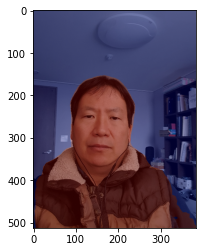

In [8]:
# 사람(person) 라벨, 즉 15를 가진 영역만 검출
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)    # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max())    # 255 normalization, seg_map.max()=15
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

* **`np.where(배열에 대한 조건문, 참일때 값, 거짓일때 값)`**
  - 배열(array)을 반환한다
  
  
* **`np.where(배열에 대한 조건문)`**
  - 인덱스를 반환한다
  
  
* **`배열이름[ np.where(배열에 대한 조건문) ]`**
  - 값을 반환한다

* **`cv2.applyColorMap(src, colormap)`**
  - src 이미지에 colormap 색상을 적용
  
  
* **`cv2.COLORMAP_JET`**
  - OpenCV 내장 컬러맵 중에 한가지
  - <img align="left" width='30%' height='30%' src='https://docs.opencv.org/3.4/colorscale_jet.jpg' />

* **`cv2.addWeighted(imgA, a, imgB,b, c)`**
  - `result = imgA * a + imgB * b + c`

#### Step 1-1-6. 세그멘테이션 결과를 원래 크기로 복원

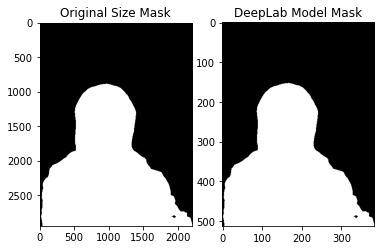

In [9]:
# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

* **`cv2.threshold(src, thresh, maxval, type)`**
  - src – input image로 single-channel 이미지.(grayscale 이미지)
  - thresh – 임계값
  - maxval – 임계값을 넘었을 때 적용할 value
  - type – thresholding type


* **thresholding type**은 아래와 같습니다.
  - `cv2.THRESH_BINARY`
  - `cv2.THRESH_BINARY_INV`
  - `cv2.THRESH_TRUNC`
  - `cv2.THRESH_TOZERO`
  - `cv2.THRESH_TOZERO_INV`
  - <img align='left' width='50%' height='50%' src='https://opencv-python.readthedocs.io/en/latest/_images/result011.jpg' />

#### Step 1-1-7. 세그멘테이션 마스크를 이용해서 배경만 추출

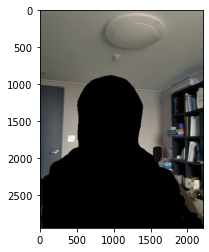

In [10]:
# 배경을 흐리게 하기 위해서 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

* **`cv2.bitwise(연산 이미지1, 연산 이미지2)`**
  - 비트 연산을 진행
  - **논리곱(`bitwise_and`), 논리합(`bitwise_or`), 배타적 논리합(`bitwise_xor`), 부정(`bitwise_not`)** 등으로 연산
  - 비트연산은 이미지에서 특정 영역을 추출할 때 유용하게 사용된다
    - **논리곱(`bitwise_and`)** : 두 그림에서 모두 흰색(1)인 부분만 흰색으로 나타남
    - **논리합(`bitwise_or`)** : 두 그림에서 모두 검은색(0)인 부분만 검정색으로 나타남
    - **배타적 논리합(`bitwise_xor`)** : 두 그림에서 값이 서로 같으면 검은색, 같지 않으면 흰색으로 나타남
    - **부정(`bitwise_not`)** : 그림에서 색이 반대로 나타남
  

#### Step 1-1-8. 배경이 흐리게 처리된 영상을 얻기

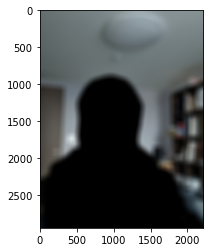

In [11]:
# 이미지를 블러(blur)하여 배경이 흐리게 처리된 영상을 얻기
img_bg_blur = cv2.blur(img_bg, (101,101))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

* **`cv2.blur(src, ksize)`**
  - src – Chennel수는 상관없으나, depth(Data Type)은 CV_8U, CV_16U, CV_16S, CV_32F or CV_64F.
  - ksize – kernel 사이즈(ex; (3,3))
  - 고주파영역을 제거함으로써 노이즈를 제거하거나 경계선을 흐리게 할 수 있음


* **Image Blurring 방법들**
  - Averaging  : `cv2.blur(src, ksize)` 
  - Gaussian Filtering  : `cv2.GaussianBlur(img, ksize, sigmaX)`
  - Median Filtering  : `cv2.medianBlur(src, ksize)`
  - Bilateral Filtering  : `cv2.bilateralFilter(src, d, sigmaColor, sigmaSpace)`


#### Step 1-1-9. 배경 영상과 사람 영상을 합치기

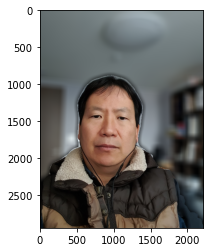

In [12]:
# 배경 영상과 사람 영상을 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

#### Step 1-1-10. 배경 흐리게 처리하는 함수 선언

In [13]:
# 배경 흐리게 처리하는 함수 선언
def my_bluring(img_path, model_dir, label_name='person', k_size=101 ):
    img_orig = cv2.imread(img_path) 
    height, width, channel = img_orig.shape
    
    # 사전에 학습된 가중치(pretrained weight)를 불러오기
    tf.io.gfile.makedirs(model_dir)
    download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
    if not os.path.exists(download_path):
        urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                       download_path)
    MODEL = DeepLabModel(download_path)
    
    # 이미지를 네트워크에 입력
    img_resized, seg_map = MODEL.run(img_orig)
    
    # 사람(person) 라벨, 즉 15를 가진 영역만 검출
    img_show = img_resized.copy()
    label_idx = LABEL_NAMES.index(label_name)
    seg_map = np.where(seg_map == label_idx, label_idx, 0) # 예측 중 사람만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
    
    # 세그멘테이션 결과(mask)를 원래 크기로 복원
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
    
    # 배경을 흐리게 하기 위해서 세그멘테이션 마스크를 이용해서 배경만 추출
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
    
    # 이미지를 블러(blur)하면 배경이 흐리게 처리된 영상을 얻기
    img_bg_blur = cv2.blur(img_bg, (k_size,k_size))    # 커널 크기 101
    
    # 배경 영상과 사람 영상을 합치기
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    
    plt.figure()
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    return img_concat


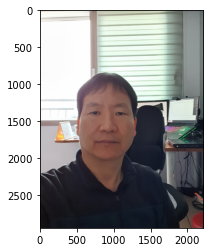

In [14]:
# 이미지 원본
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/lyb3.jpg'
img_orig = cv2.imread(img_path) 
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

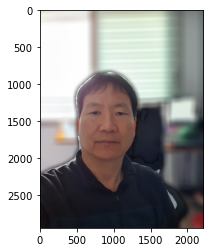

In [15]:
# 인물모드 사진
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/lyb3.jpg'
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'

img_blur = my_bluring(img_path, model_dir, label_name='person', k_size=101 )

plt.show()

#### Step 1-1-11. 파일 이름이 lyb로 시작하는 이미지 모두 아웃포커싱 수행

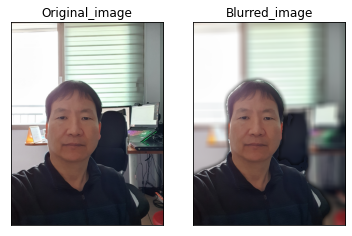

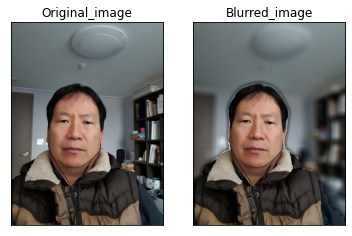

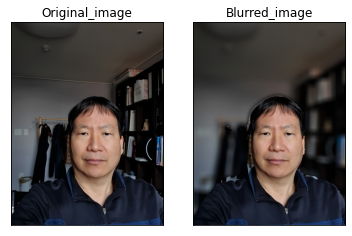

In [16]:
# 파일 이름이 lyb로 시작하는 이미지 모두 아웃포커싱 수행
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
dir_path = os.getenv('HOME')+'/aiffel/human_segmentation/images'
file_list = os.listdir(dir_path)
file_list_lyb = [file for file in file_list if file.startswith("lyb")]


         
for file in file_list_lyb:
    img_path = os.path.join(dir_path, file) 
    img_blur = my_bluring(img_path, model_dir, label_name='person', k_size=101)
    
    img_orig = cv2.imread(img_path) 
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    img_blur = cv2.cvtColor(img_blur, cv2.COLOR_BGR2RGB)
    
    images = [img_orig, img_blur]
    titles =['Original_image','Blurred_image']
    
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
        
plt.show()

### Step 1-2. 고양이 사진 아웃포커싱

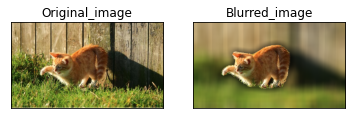

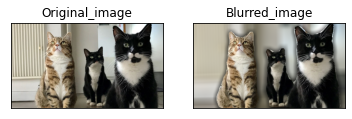

In [17]:
# 파일 이름이 cat로 시작하는 이미지 모두 아웃포커싱 수행
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
dir_path = os.getenv('HOME')+'/aiffel/human_segmentation/images'
file_list = os.listdir(dir_path)
file_list_cat = [file for file in file_list if file.startswith("cat")]


         
for file in file_list_cat:
    img_path = os.path.join(dir_path, file) 
    img_blur = my_bluring(img_path, model_dir, label_name='cat', k_size=51)
    
    img_orig = cv2.imread(img_path) 
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    img_blur = cv2.cvtColor(img_blur, cv2.COLOR_BGR2RGB)
    
    images = [img_orig, img_blur]
    titles =['Original_image','Blurred_image']
    
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
        
plt.show()

### Step 1-3. 배경전환 크로마키 사진

#### Step 1-3-1. 배경과 전경 이미지 불러오기

(1050, 1680, 3)


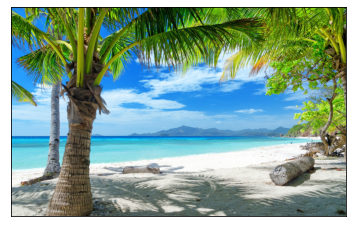

In [18]:
# 배경 이미지 읽기
background_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/sea2.jpg'
background = cv2.imread(background_path) 
background_rgb = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)

print(background.shape)
plt.imshow(background_rgb)
plt.xticks([]), plt.yticks([])
plt.show()

(2944, 2208, 3)


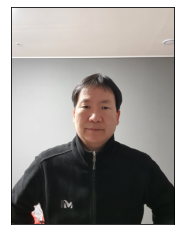

In [19]:
# 전경 이미지 읽기
foreground_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/chromakey.jpg'
foreground = cv2.imread(foreground_path)
foreground_rgb = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)

print(foreground.shape)
plt.imshow(foreground_rgb)
plt.xticks([]), plt.yticks([])
plt.show()

#### Step 1-3-2. ROI 영역 설정에 사용할 mask 생성

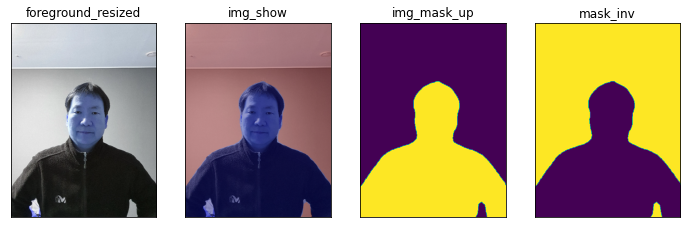

In [20]:
# 이미지를 네트워크에 입력
foreground_resized, seg_map = MODEL.run(foreground)

# 사람(person) 라벨, 즉 15를 가진 영역만 검출
img_show = foreground_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)    # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max())    # 255 normalization, seg_map.max()=15
img_mask = img_mask.astype(np.uint8)

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask,0.4, 0.0)


# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, foreground_resized.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, mask_inv = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY_INV)


plt.figure(figsize=[12, 12])
plt.subplot(1, 4, 1)
plt.imshow(foreground_resized)
plt.title('foreground_resized')
plt.xticks([]), plt.yticks([])

plt.subplot(1, 4, 2)
plt.imshow(img_show)
plt.title('img_show')
plt.xticks([]), plt.yticks([])

plt.subplot(1, 4, 3)
plt.imshow(img_mask_up)
plt.title('img_mask_up')
plt.xticks([]), plt.yticks([])

plt.subplot(1, 4, 4)
plt.imshow(mask_inv)
plt.title('mask_inv')
plt.xticks([]), plt.yticks([])

plt.show()

* 노랑 : 255
* 와인 : 0

#### Step 1-3-3. ROI 영역 설정 

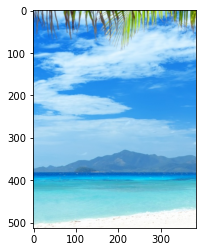

In [21]:
# ROI 영역 설정 (background 이미지 정중앙)
background_height, background_width, _ = background.shape            # 1050, 1680, 3
foreground_height, foreground_width, _ = foreground_resized.shape       # 513, 384, 3

x = (background_height - foreground_height) // 2 
y = (background_width - foreground_width) // 2

roi_background = background[x: x+foreground_height, y: y+foreground_width]

plt.imshow(cv2.cvtColor(roi_background, cv2.COLOR_BGR2RGB))
plt.show()

#### Step 1-3-4. ROI_background에서 foreground 부분 추출

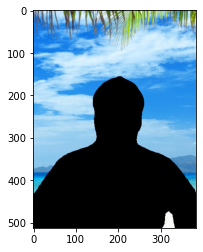

In [22]:
# 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_mask_foreground = cv2.bitwise_not(img_mask_color)
img_mask_background = cv2.bitwise_and(roi_background, img_mask_foreground)

plt.imshow(cv2.cvtColor(img_mask_background, cv2.COLOR_BGR2RGB))
plt.show()

#### Step 1-3-5. ROI_background와 foreground_resized 합성

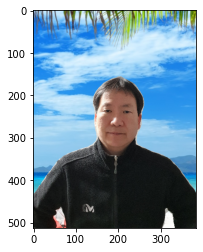

In [23]:
# 배경 영상과 사람 영상을 합치기
img_concat = np.where(img_mask_color==255, foreground_resized, img_mask_background)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

#### Step 1-3-6. 합성된 roi_foreground의 값을 roi_background로 복사

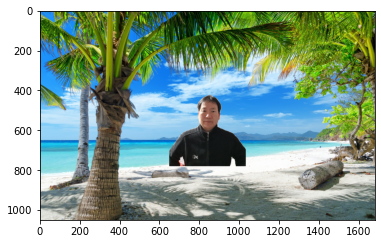

In [24]:
# img_concat 있는 값들을 roi_background로 복사
np.copyto(roi_background, img_concat)    

plt.imshow(cv2.cvtColor(background, cv2.COLOR_BGR2RGB))
plt.show()

## Step 2. 사진에서 문제점 찾기
그러나 여러분들의 사진에는 무언가 문제점이 있을 것입니다.

* 아래 사진에도 문제점이 몇가지 있었습니다. 
  - 예를 들어 뒤에 걸린 옷이 인물 영역에 포함되어 blur되지지 않고 나온다던가 하는 경우입니다. ㅠㅠ 그 외 다른 문제들이 눈에 띄시나요?   
  - 아래 사진에는 이상한 점이 최소 2개 이상 더 있습니다. 어떤 문제가 있는지 찾아서 아래 사진처럼 표시해 봅시다.
  
  
* 추가로 여러분이 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 아래 사진처럼 표시해 봅시다. 
* 표시한 이미지들을 jupyter notebook에 포함하여 제출해 주세요.

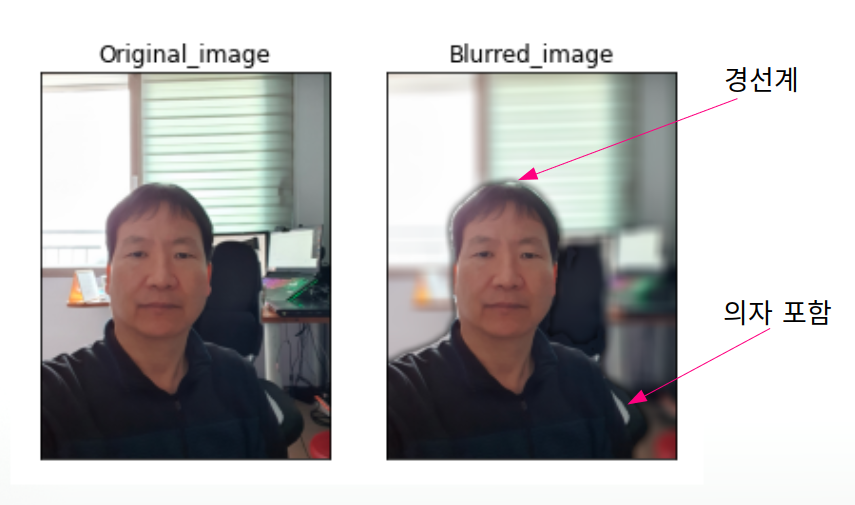

* 배경을 흐리게 하기 위해서 커널 크기를 키우면 경계선이 나타났다.
* 옷 색상과 비슷한 배경 중에서 일부분이 사람의 일부분으로 인식되었다. 

## Step 3. 해결 방법을 제안해 보기
아주 간단히 멋진 카메라앱 서비스를 만들어 출시할 수 있을 것 같았지만, 지금같은 완성도로는 어림도 없습니다. 소비자들의 눈높이는 그리 호락호락하지 않고, 엔지니어인 여러분들은 답을 찾아내야 합니다.

생각해 볼만한 주제를 아래에 몇가지 제시해 봅니다. 
* 아래를 읽어본 후, 여러분이 만든 인물모드 사진의 문제점을 해결할 방안을 정리하여 제안해 주시기 바랍니다.
  - 단순히 'XXX 기술을 사용한다.' 정도의 선언적 솔루션이 아니라, 
  - 여러분들이 선택한 기술이 DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션이어야 합니다.
 
### 세그멘테이션의 한계
* Semantic segmentation의 부정확성이 여러가지 문제를 발생시키는 주요 원인입니다. 
* 피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation) 하지만 
* 이를 따라한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기는 힘듭니다.


### 피사계 심도 이해하기
우선 **피사계심도의 개념**부터 명확히 이해해 봅시다.

* 참고자료 : https://ggyul.tistory.com/12


### 3D Depth Camera 활용하기
* 카메라 2개를 통해 생성한 3d 영상으로 인물모드를 더 정확하게 만들 수 있을까요? 
* 우리는 카메라 1대가 찍은 영상에서 semantic segmentation을 시도하였고, 그 결과가 정확하지 않았습니다. 
* 요즘 스마트폰의 카메라는 렌즈가 2개 달려있지요? 왜 굳이 그렇게까지 하는지 아래 링크를 보면서 이해해 봅시다.

* 참고자료 : https://m.blog.naver.com/panoptics/221336152952


### 깊이 영상(Depth image) 활용하기
* 하지만 꼭 카메라가 2개여야 할까요? 아래 이미지는 **Struct2Depth** 라는 기법을 소개한 Google Brain의 논문에 있는 이미지입니다. 
* 세번째 컬럼이 보다 명확하게 depth에 따른 물체인식을 보여 주는데, 이것은 **LiDAR**가 없이도 아주 정확한 segmentation을 동반한 **depth sensor**가 가능함을 보여줍니다.

* 참고자료 : https://towardsdatascience.com/depth-prediction-autonomous-driving-18d05ff25dd6
* 참고자료 : https://sites.google.com/view/struct2depth

<img src='https://aiffelstaticprd.blob.core.windows.net/media/images/E-14-14.max-800x600.png' alt='drawing' width='50%'/>


### IR(적외선)을 활용한 사례
* **구글 pixel4에 IR 카메라**가 달려있는데, 이를 통해 보다 멋진 **3d depth sensing**이 가능하다는군요.

* 참고자료 : https://ai.googleblog.com/2020/04/udepth-real-time-3d-depth-sensing-on.html
  
  
엔지니어로서 본인이 선택한 솔루션을 잘 설명해 주세요. 
가능하다면 순서도(Flow Chart)를 활용하면 좋습니다. 멋진 아이디어를 기대하겠습니다!!

### 메커니즘이 포함된 솔루션
* 여러분들이 선택한 기술이 DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션이어야 합니다.
  - 1) Semantic Segmentation 문제점을 보완하기 위해서 깊이 영상(Depth image)과 IR(적외선) 영상을 RGB 영상과 함께 고려한다.
  - 2) 깊이 영상(Depth image) 활용하면 거리를 기준으로 크로마키를 할 수 있기 때문에 동일 라벨이라도 거리가 다르면 구분할 수 있겠다.
  - 3) IR(적외선)을 활용하면 물체마다 방출되는 적외선의 차이가 다르기 때문에 가까이 있는 라벨들의 경계를 효과적으로 찾을 수 있겠다. 

## 회고

1) DeepLabModel에서 사용한 텐서플로 버전1의 내용을 충분히 숙지하지 못하고 넘어가는 것이 아쉽다.   
     텐서플로 버전2의 형식으로 변경하려면 어떻게 해야하는지 알고 싶다.  


2) 이미지 처리하는데 OpenCV와 Numpy의 사용을 많이 한다는 것을 알게 되었다.  
    - `cv2.bitwise(), cv2.applyColorMap(), cv2.addWeighted(), cv2.threshold(), cv2.cvtColor(), cv2.blur()`  
    - `np.where(), np.copyto()`  


3) 배경 이미지의 크기와 전경 이미지의 크기가 동일 한 것을 사용해야만 크로마키가 된다는 것을 알게되었다.  
    - 축소된 전경 이미지와 같은 크기를 갖는 배경이미지의 ROI 영역에 대해서 크로마키를 진행하고나서 전체의 배경 이미지로 복사한다.  


4) 아이펠 대전에서 내가 하고 싶었던 3D depth 이미지와 IR 이미지의 내용이 이번 Exploration에서 나와서 재미 있었다.  
    - 라벨 이름이 없는 경우에는 어떻게 해야하는지 알고 싶다.  
    - 3D depth 이미지와 IR 이미지의 내용을 좀더 안내해주면 좋을텐데..